In [2]:
import sagemaker

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name

role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


s3.Object(bucket_name='sagemaker-us-west-2-071681976313', key='sagemaker/data-raw/10246.png')
(1024, 1024, 3)
(array([0., 1.], dtype=float32), array([3095229,   50499]))


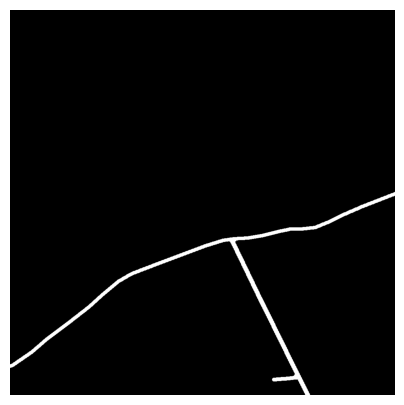

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import boto3
import io

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-mnist/segdata2/train/masks/"

s3 = boto3.client('s3')
content = s3.list_objects(Bucket=bucket, Prefix=prefix)

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket)

obj = bucket.Object(content.get('Contents')[0].get('Key'))
print(obj)

file_stream = io.BytesIO()
obj.download_fileobj(file_stream)
img = mpimg.imread(file_stream, "jpeg")
print(img.shape)
print(np.unique(img, return_counts=True))

figure = plt.figure(figsize=(5, 5))
plt.axis("off")
plt.imshow(img)
#plt.show()

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


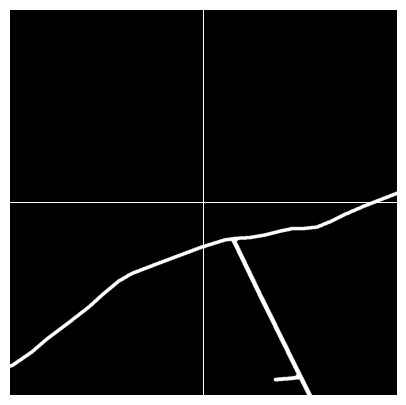

In [4]:
images_split = []
x, y, z = img.shape

splits_x , splits_y = 2, 2

for i in range(splits_x):
    for j in range(splits_y):
        x_range = int((x/splits_x))
        y_range = int((y/splits_y))
        images_split.append(img[x_range*i:x_range*(i+1), y_range*j:y_range*(j+1), :])

figure = plt.figure(figsize=(5, 5))

for i in range(splits_x*splits_y):
    figure.add_subplot(splits_x, splits_y, i+1)
    plt.axis("off")
    plt.imshow(images_split[i])
    print(images_split[i].shape)
plt.subplots_adjust(wspace=0, hspace=0.00186)
#plt.show()

In [ ]:
import numpy as np
import boto3
import io
from PIL import Image


train_split, test_split = 0.8, 0.2

bucket = sagemaker_session.default_bucket()
prefix_in = "sagemaker/data-raw/"
prefix_out_train = "sagemaker/seg-data/train/images/"
prefix_out_test = "sagemaker/seg-data/test/images/"

contents = []

s3 = boto3.client('s3')
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket, Prefix=prefix_in)

for page in pages:
    contents += page['Contents']
        
print(len(contents))
train_content = contents[1:int(len(contents) * train_split)]
test_content = contents[int(len(contents) * train_split):]
print(len(train_content))
print(len(test_content))

s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket)

def split_images(image_list, output_loc, s3_bucket):
    for i in image_list:
        key = i.get('Key')
        obj = s3_bucket.Object(key)
        
        file_stream = io.BytesIO()
        obj.download_fileobj(file_stream)
        img = mpimg.imread(file_stream, "jpeg")
    
        x, y, z = img.shape
    
        splits_x , splits_y = 2, 2
    
        for j in range(splits_x):
            for k in range(splits_y):
                x_range = int((x/splits_x))
                y_range = int((y/splits_y))
                new_img = img[x_range*j:x_range*(j+1), y_range*k:y_range*(k+1), :]
    
                im = Image.fromarray(new_img)
                bits = io.BytesIO()
                im.save(bits, "jpeg")
                bits.seek(0, 0)
                save = output_loc + key.split("/")[-1].split(".")[0] + "_" + str(j) + "_" + str(k) + ".jpg"
                s3.put_object(Bucket=s3_bucket.name, Key=save, Body=bits, ContentType="image/jpg")


split_images(train_content, prefix_out_train, bucket)
split_images(test_content, prefix_out_test, bucket)

6227
4980
1246
[{'Key': 'sagemaker/DEMO-pytorch-mnist/segdata/train/images/100034.jpg', 'LastModified': datetime.datetime(2024, 6, 27, 18, 11, 13, tzinfo=tzlocal()), 'ETag': '"ce213e8803c5f420ad73943be5326c11"', 'Size': 517271, 'StorageClass': 'STANDARD'}, {'Key': 'sagemaker/DEMO-pytorch-mnist/segdata/train/images/100081.jpg', 'LastModified': datetime.datetime(2024, 6, 27, 18, 11, 13, tzinfo=tzlocal()), 'ETag': '"ae1fe7fd9b6612cf557015d6a9d0ea7a"', 'Size': 510447, 'StorageClass': 'STANDARD'}]


In [ ]:
import numpy as np
import boto3
import io
from PIL import Image

bucket = sagemaker_session.default_bucket()
prefix_in = "sagemaker/DEMO-pytorch-mnist/segdata/train/masks/"
prefix_out_train = "sagemaker/seg-data/train/masks/"
prefix_out_test = "sagemaker/seg-data/test/masks/"

s3 = boto3.client('s3')
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket, Prefix=prefix_in)

for page in pages:
    contents += page['Contents']

train_content = contents[1:int(len(contents) * train_split)]
test_content = contents[int(len(contents) * train_split):]
print(len(train_content))
print(len(test_content))

s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket)

def split_masks(mask_list, output_loc, s3_bucket):
    for i in mask_list:
        key = i.get('Key')
        obj = s3_bucket.Object(key)
        
        file_stream = io.BytesIO()
        obj.download_fileobj(file_stream)
        img = mpimg.imread(file_stream, "jpeg")
    
        x, y, z = img.shape
    
        splits_x , splits_y = 2, 2
    
        for j in range(splits_x):
            for k in range(splits_y):
                x_range = int((x/splits_x))
                y_range = int((y/splits_y))
                new_img = img[x_range*j:x_range*(j+1), y_range*k:y_range*(k+1), :] * 255

                im = Image.fromarray(new_img.astype(np.uint8))
                bits = io.BytesIO()
                im.save(bits, "png")
                bits.seek(0, 0)
                save = output_loc + key.split("/")[-1].split(".")[0] + "_" + str(j) + "_" + str(k) + ".png"
                s3.put_object(Bucket=s3_bucket.name, Key=save, Body=bits, ContentType="image/png")

split_masks(train_content, prefix_out_train, bucket)
split_masks(test_content, prefix_out_test, bucket)